In [60]:
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('train_features1.pkl',mode='rb')as file:
    train_features1=pickle.load(file)
with open('train_labels.pkl',mode='rb')as file:
    train_labels=pickle.load(file)
with open('test_features1.pkl',mode='rb')as file:
    test_features1=pickle.load(file)
with open('test_labels.pkl',mode='rb')as file:
    test_labels=pickle.load(file)
with open('dataframe.pkl',mode='rb')as file:
    df=pickle.load(file)

In [5]:
lr_0 = LogisticRegression( random_state=5)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 5,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [6]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [7]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=5)

# Fit the random search model
random_search.fit(train_features1, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
FINISHED--------------------


In [8]:

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.4}

The mean accuracy of a model with these hyperparameters is:
0.9566405889702244


In [9]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.2, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=5)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 5)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features1, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
FINISHED--------------------


In [10]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.9111111111111112, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9584


In [11]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.9111111111111112, class_weight='balanced',
                   multi_class='multinomial', random_state=5, solver='sag')

In [13]:
best_lrc.fit(train_features1, train_labels)

LogisticRegression(C=0.9111111111111112, class_weight='balanced',
                   multi_class='multinomial', random_state=5, solver='sag')

In [15]:
lrc_pred = best_lrc.predict(test_features1)

In [17]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_lrc.predict(train_features1)))

The training accuracy is: 
0.9788471708090957


In [18]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, lrc_pred))

The test accuracy is: 
0.9431137724550899


In [85]:
# Classification report
print("Classification report for Log Regression")
print(classification_report(test_labels,lrc_pred))

Classification report for Log Regression
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       0.91      0.98      0.94        49
           2       0.95      0.90      0.92        60
           3       0.89      0.96      0.92        81
           4       0.98      0.90      0.94        72

    accuracy                           0.94       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.95      0.94      0.94       334



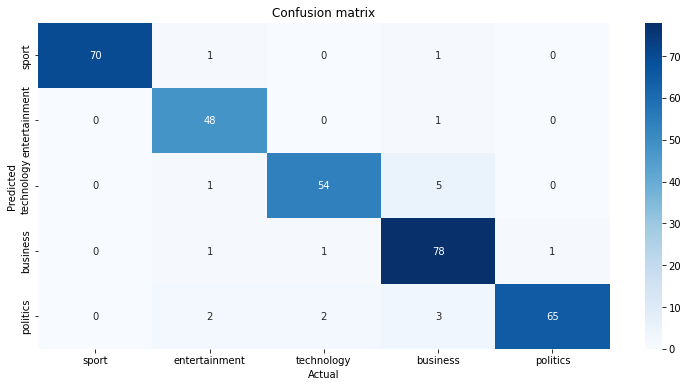

In [83]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig('Log_confusion.png',bbox_inches = "tight")

In [76]:
from sklearn.metrics import roc_auc_score
pred_prob = best_lrc.predict_proba(test_features1)

In [77]:
fpr2, tpr2, thresh2 = roc_curve(test_labels, pred_prob[:,1], pos_label=1)

In [78]:
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

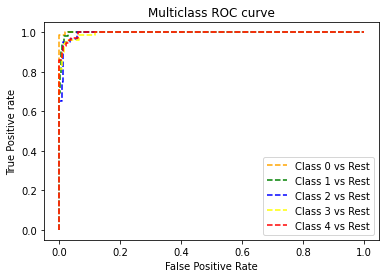

In [87]:
fpr = {}
tpr = {}
thresh ={}
y_prob_pred_cnb = best_lrc.predict_proba(test_features1)
n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, y_prob_pred_cnb[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC');


In [82]:
roc_auc_score(test_labels, y_prob_pred_cnb, multi_class='ovo', average='weighted')

0.9966236744198678

# Second Features

In [27]:
with open('train_features2.pkl',mode='rb')as file:
    train_features2=pickle.load(file)
with open('test_features2.pkl',mode='rb')as file:
    test_features2=pickle.load(file)

In [28]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [29]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=5)

# Fit the random search model
random_search.fit(train_features2, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
FINISHED--------------------


In [30]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.9}

The mean accuracy of a model with these hyperparameters is:
0.9603417771405094


In [31]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.2, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag','saga']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=5)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 5)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features2, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
FINISHED--------------------


In [32]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.8222222222222222, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9648


In [33]:
best_lrc2 = grid_search.best_estimator_
best_lrc2

LogisticRegression(C=0.8222222222222222, class_weight='balanced',
                   multi_class='multinomial', random_state=5, solver='sag')

In [34]:
best_lrc2.fit(train_features2, train_labels)

LogisticRegression(C=0.8222222222222222, class_weight='balanced',
                   multi_class='multinomial', random_state=5, solver='sag')

In [35]:
lrc_pred2 = best_lrc2.predict(test_features2)

In [36]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_lrc2.predict(train_features2)))

The training accuracy is: 
0.9799048122686409


In [37]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, lrc_pred2))

The test accuracy is: 
0.9520958083832335


In [38]:
# Classification report
print("Classification report Logistic regression")
print(classification_report(test_labels,lrc_pred2))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.92      0.98      0.95        49
           2       0.95      0.92      0.93        60
           3       0.91      0.96      0.93        81
           4       0.99      0.92      0.95        72

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



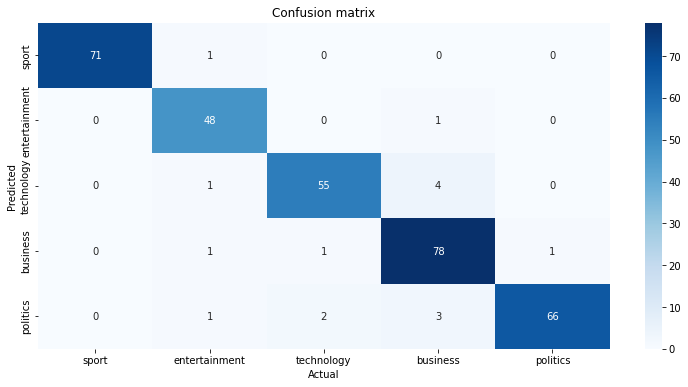

In [39]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, lrc_pred2)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

# base model

In [40]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(train_features1, train_labels)
accuracy_score(test_labels, base_model.predict(test_features1))

0.9431137724550899

In [41]:
best_lrc.fit(train_features1, train_labels)
accuracy_score(test_labels, best_lrc.predict(test_features1))

0.9431137724550899

In [42]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(train_features2, train_labels)
accuracy_score(test_labels, base_model.predict(test_features2))

0.9491017964071856

In [43]:
best_lrc2.fit(train_features2, train_labels)
accuracy_score(test_labels, best_lrc2.predict(test_features2))

0.9520958083832335

In [45]:
d = {
     'Model': ['Logistic Regression1','Logistic Regression2'],
     'Training Set Accuracy': [accuracy_score(train_labels, best_lrc.predict(train_features1)),
                               accuracy_score(train_labels, best_lrc2.predict(train_features2))],
     'Test Set Accuracy': [accuracy_score(test_labels, lrc_pred),accuracy_score(test_labels, lrc_pred2)]
}

df_models_lrc = pd.DataFrame(d)
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression1,0.978847,0.943114
1,Logistic Regression2,0.979905,0.952096


In [91]:
df_models_rfc=pd.read_pickle('RFC.accuracy.pkl')
df_models_svc=pd.read_pickle('SVM.accuracy.pkl')
df_models_mnbc=pd.read_pickle('NB.accuracy.pkl')
df_models_knnc=pd.read_pickle('KNN.accuracy.pkl')

In [93]:
pd.concat([df_models_rfc, df_models_svc,df_models_mnbc,df_models_knnc,df_models_lrc], axis=0)

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest1,0.998942,0.925150
1,Random Forest2,1.000000,0.931138
0,SVM1,0.998942,0.949102
1,SVM2,0.999471,0.946108
0,Multinomial Naïve Bayes1,0.953993,0.931138
1,Multinomial Naïve Bayes2,0.958223,0.931138
0,KNN1,0.953993,0.928144
1,KNN2,0.955050,0.937126
0,Logistic Regression1,0.978847,0.943114
1,Logistic Regression2,0.979905,0.952096
